In [1]:
# Import our dependencies
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df.drop(columns=["EIN", "NAME"], inplace=True)
application_df.head(10)

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1
5,T3,Independent,C1200,Preservation,Trust,1,0,N,5000,1
6,T3,Independent,C1000,Preservation,Trust,1,100000-499999,N,31452,1
7,T3,Independent,C2000,Preservation,Trust,1,10M-50M,N,7508025,1
8,T7,Independent,C1000,ProductDev,Trust,1,1-9999,N,94389,1
9,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0


In [3]:
# Look at APPLICATION_TYPE value counts for binning
application_counts = application_df.APPLICATION_TYPE.value_counts()
application_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T25        3
T14        3
T15        2
T29        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

In [4]:
# Determine which values to replace if counts are less than ...?
replace_application = list(application_counts[application_counts < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
Other     7262
Name: APPLICATION_TYPE, dtype: int64

In [5]:
# Look at CLASSIFICATION value counts for binning
classification_counts = application_df.CLASSIFICATION.value_counts()
classification_counts

In [6]:
# Determine which values to replace if counts are less than ..?
replace_classification = list(classification_counts[classification_counts < 1000].index)

# Replace in dataframe
for cls in replace_classification:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
Other     6062
C1200     4837
Name: CLASSIFICATION, dtype: int64

In [7]:
ask_amt_counts = application_df["ASK_AMT"].value_counts()

<AxesSubplot:ylabel='Density'>

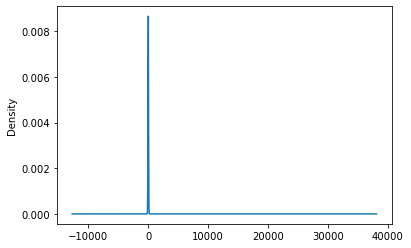

In [8]:
ask_amt_counts.plot.density()

In [17]:
# Bin ask amounts
replace_ask_amt = list(ask_amt_counts[ask_amt_counts > 5000].index)

# Replace in dataframe
for amt in replace_ask_amt:
    application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,"Other")
    
# Check to make sure binning was successful
application_df.ASK_AMT.value_counts()

Other     25398
15583         3
6725          3
10478         3
63981         3
          ...  
5646          1
5643          1
103946        1
22023         1
49150         1
Name: ASK_AMT, Length: 8747, dtype: int64

In [9]:
# Generate our categorical variable lists
cat_values = application_df.dtypes[application_df.dtypes == "object"].index.tolist()

cat_values

['APPLICATION_TYPE',
 'AFFILIATION',
 'CLASSIFICATION',
 'USE_CASE',
 'ORGANIZATION',
 'INCOME_AMT',
 'SPECIAL_CONSIDERATIONS']

In [10]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[cat_values]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(cat_values)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T3,AFFILIATION_CompanySponsored,AFFILIATION_Family/Parent,AFFILIATION_Independent,AFFILIATION_National,AFFILIATION_Other,AFFILIATION_Regional,CLASSIFICATION_C1000,CLASSIFICATION_C1200,...,INCOME_AMT_1-9999,INCOME_AMT_10000-24999,INCOME_AMT_100000-499999,INCOME_AMT_10M-50M,INCOME_AMT_1M-5M,INCOME_AMT_25000-99999,INCOME_AMT_50M+,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y
0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Merge one-hot encoded features and drop the originals
app_df = application_df.merge(encode_df, left_index=True, right_index=True)
app_df.drop(columns=["APPLICATION_TYPE","CLASSIFICATION","AFFILIATION","USE_CASE","ORGANIZATION","INCOME_AMT","SPECIAL_CONSIDERATIONS"], inplace=True)

app_df.head()

In [ ]:
# Split our preprocessed data into our features and target arrays
y = app_df.IS_SUCCESSFUL
X = app_df.drop(columns=["IS_SUCCESSFUL"]).values


# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [ ]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [ ]:
# Define the model - Deep Neural Net with additional hidden layer and increased neurons

number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  100
hidden_nodes_layer2 = 50
#hidden_nodes_layer3 = 25

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="tanh"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
#nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

In [ ]:
# Define the checkpoint path and filenames
os.makedirs("checkpoints/",exist_ok=True)
checkpoint_path = "checkpoints/weights.{epoch:02d}.hdf5"

In [ ]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=5)

In [ ]:
# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100)

In [ ]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

In [ ]:
# Export the model to HDF5 file
nn.save("AlphabetSoupCharity_Optimization.h5")

In [ ]:
#DEEP NEURAL NET: from Deeplearning_tabular
number_input_features = len(X_train_scaled[0])
hidden_nodes_layer1 =  80
hidden_nodes_layer2 = 30

nn_new = tf.keras.models.Sequential()

# First hidden layer
nn_new.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn_new.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn_new.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Compile the model
nn_new.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


# Evaluate the model using the test data
model_loss, model_accuracy = nn_new.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")